In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import pairwise_distances

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [2]:
def read_xy(x_fp, y_fp):
    x = pd.read_csv(x_fp, header=None, index_col=0)
    y = pd.read_csv(y_fp, index_col=0)
    return {'x': x, 'y': y}

In [3]:
def count_y_class(y_df):
    y_class = y_df.apply(lambda x: ''.join([str(i) for i in x]), axis=1).to_frame(name='class')
    # y_class.head(2)
    
    y_class2num = y_class['class'].value_counts().to_frame(name='num')
    y_class2num['n_error'] = 0
    return y_class2num

In [4]:
def predict_y(x, model):
    y_pred_raw = model.predict(x)
    y_pred_bool = tf.math.sigmoid(y_pred_raw)
    y_pred_bool = y_pred_bool.numpy()
    y_pred_bool[y_pred_bool >= 0.5] = 1
    y_pred_bool[y_pred_bool < 0.5] = 0
    return y_pred_bool

In [5]:
def predict_y_reg(x, model):
    y_pred_raw = model.predict(x)
    y_pred_int = np.rint(y_pred_raw)
    return y_pred_int.astype(np.int)

In [6]:
def count_pred_error_in_class(y, y_pred):
    pred_comp_bool = np.all(y == y_pred, axis=1)
    y_pred_error = y_pred[~pred_comp_bool]
    y_class = y.apply(lambda x: ''.join([str(i) for i in x]), axis=1).to_frame(name='class')
    y_pred_error_count_by_class = y_class.loc[y_class.index.isin(y_pred_error.index), 'class'].value_counts().to_frame(name='n_error')
    
    y_class2num = y_class['class'].value_counts().to_frame(name='num')
    y_class2num['n_error'] = 0
    y_class2num.loc[y_pred_error_count_by_class.index, 'n_error'] = y_pred_error_count_by_class.n_error
    return y_class2num

In [7]:
model = keras.models.load_model('../big-data/moses_dataset/model_mol2vec/model_reg.h5')

In [8]:
xy_train = read_xy(x_fp='../big-data/moses_dataset/model_mol2vec/x_training_set_mol2vec.csv',   
                                       y_fp='../big-data/moses_dataset/model_mol2vec/y_train_regression.csv')
x_train = xy_train['x']
y_train = xy_train['y']

In [9]:
x_train.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
id6,-36.743,-10.796,11.868,10.114,2.560,-39.522,-4.150,25.588,-36.223,-25.428,...,2.574,-11.161,5.21,-56.205,-24.180,-15.044,-25.268,-37.867,-22.767,36.371
id8,-1.365,-28.529,-44.825,-17.365,-48.859,-56.681,82.548,-3.718,-29.935,-16.377,...,16.007,7.878,-50.93,-59.641,-7.269,-19.215,-26.684,-61.526,-36.618,9.412


In [10]:
y_train.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id6,1,0,4,1,1,0,1,1
id8,0,0,5,0,1,0,2,0


In [11]:
y_train_bool = y_train.copy()
y_train_bool[y_train >= 1] = 1

In [12]:
y_train_class2num = count_y_class(y_df=y_train_bool)
print(y_train_class2num.shape)
y_train_class2num.head(2)

(98, 2)


,num,n_error
10110011,4500,0
10100011,4500,0


In [13]:
y_train_pred_int = predict_y_reg(model=model, x=x_train)
y_train_pred = pd.DataFrame(data=y_train_pred_int, index=y_train.index, columns=y_train.columns)
y_train_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id6,0,0,4,0,1,0,1,1
id8,0,0,5,0,1,0,2,0


In [14]:
y_train_pred_bool = y_train_pred.copy()
y_train_pred_bool[y_train_pred >= 1] = 1
y_train_class2num2 = count_pred_error_in_class(y=y_train_bool, y_pred=y_train_pred_bool)
y_train_class2num2.head(2)

,num,n_error
10110011,4500,380
10100011,4500,314


In [15]:
y_train_class2num2.sum()

num        155970
n_error      8447
dtype: int64

In [16]:
1-8447/155970

0.9458421491312432

### test

In [17]:
xy_test = read_xy(x_fp='../big-data/moses_dataset/model_mol2vec/x_test_set_mol2vec.csv', 
                                     y_fp='../big-data/moses_dataset/model_mol2vec/y_test_regression.csv')
x_test = xy_test['x']
y_test = xy_test['y']

In [18]:
x_test.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
id27,-1.856,-56.556,-17.655,-0.635,-14.021,-47.397,60.738,4.549,-11.275,-29.846,...,46.195,17.980,-38.201,-63.067,-7.260,-18.807,-26.718,-65.773,-32.008,-0.152
id39,-10.020,-37.893,5.512,4.392,-16.273,-43.165,34.261,37.852,-56.066,6.019,...,24.346,-14.992,-52.569,-75.148,-26.165,17.749,-3.785,-68.614,-17.951,46.924


In [19]:
y_test.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,4,0,2,0,2,0
id39,2,0,2,0,2,1,2,1


In [20]:
y_test_pred = predict_y_reg(x=x_test, model=model)
y_test_pred = pd.DataFrame(data=y_test_pred, index=y_test.index, columns=y_test.columns)
y_test_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,4,0,2,0,2,0
id39,2,0,2,0,1,1,2,1


In [21]:
y_test_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,4,0,2,0,2,0
id39,2,0,2,0,1,1,2,1


In [22]:
y_test_bool = y_test.copy()
y_test_pred_bool = y_test_pred.copy()
y_test_bool[y_test >= 1] = 1
y_test_pred_bool[y_test_pred >= 1] = 1
y_test_class2num = count_pred_error_in_class(y=y_test_bool, y_pred=y_test_pred_bool)
y_test_class2num.head(2)

,num,n_error
10101010,5000,342
10101111,5000,100


In [23]:
y_test_class2num.sum()

num        48207
n_error     3332
dtype: int64

In [24]:
7821 / 48207, 6818 / 48207, 2978/48207, 5851/38676, 20535/48207, 3332/48207

(0.16223784927500157,
 0.14143174227809238,
 0.06177526085423279,
 0.15128244906401903,
 0.42597548073931174,
 0.06911859273549485)

In [25]:
y_test_class2num['class_in_train'] = 0
y_test_class2num.loc[y_test_class2num.index.isin(y_train_class2num2.index), 'class_in_train'] = 1

In [26]:
y_test_class2num['accuray_in_each_class'] = 1 - y_test_class2num['n_error'] / y_test_class2num['num']

In [27]:
y_test_class2num.head()

,num,n_error,class_in_train,accuray_in_each_class
10101010,5000,342,0,0.93160
10101111,5000,100,0,0.98000
10111111,5000,638,0,0.87240
11101010,5000,396,0,0.92080
11000011,3826,73,0,0.98092


In [28]:
y_test_class2num.to_csv('../big-data/moses_dataset/model_mol2vec/y_test_class2num_reg_model_mol2vec_new.csv')

### embedding vector

In [29]:
m_part1 = keras.models.load_model('../big-data/moses_dataset/model_mol2vec/m_part1_reg.h5')
m_part1

In [30]:
x_train_test = x_train.append(x_test)
x_train_test.shape

(204177, 100)

In [33]:
cid2smiles = pd.read_csv('../big-data/moses_dataset/result/mol2md_with_cid.csv', index_col='cid', usecols=['smiles', 'cid'])
cid2smiles.head(2)

,smiles
cid,
id2,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
id3,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1


In [64]:
smiles_x_train_test = x_train_test.copy()
smiles_x_train_test['smiles'] = x_train_test.index.map(lambda x: cid2smiles.loc[x, 'smiles'])
smiles_x_train_test.set_index('smiles', inplace=True)
smiles_x_train_test.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
smiles,,,,,,,,,,,,,,,,,,,,,
CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,23.425,3.503,-10.885,-29.461,27.768,-9.342,14.281,-48.240,1.767,-0.328,...,8.005,9.494,-23.133,-0.944,-13.409,-20.449,-15.793,-17.295,-6.348,2.038
COc1ccccc1OC(=O)Oc1ccccc1OC,45.314,1.383,-3.867,-7.540,-13.052,34.788,32.245,-44.028,5.547,2.348,...,-5.454,5.978,-40.544,-51.711,-12.974,-5.763,-40.700,-33.748,-29.275,-21.032


In [31]:
x_embedding = m_part1.predict(x_train_test)
type(x_embedding)

numpy.ndarray

In [32]:
x_embedding = pd.DataFrame(data=x_embedding, index=x_train_test.index)
x_embedding.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,,,,,,,,,,,,,,,,,,,,,
id6,8.015435,42.553406,7.761578,24.478992,6.927800,-1.758099,-1.404098,31.323586,6.068540,24.564615,...,-1.758099,25.490200,-1.758099,17.449503,-1.758099,-1.757850,-1.758099,-1.758099,70.930901,-1.758099
id8,5.744818,45.429264,34.519726,31.130407,-1.758099,-1.758099,-1.622563,54.093750,-1.758099,24.393270,...,-1.758099,23.093681,-1.758099,-1.757834,-1.758099,5.502191,-1.758099,-1.758099,106.119667,-1.758099


##### fragment embedding

In [93]:
frag2vec = pd.read_csv('../big-data/moses_dataset/model_mol2vec/.csv', index_col='fragment')
frag2vec.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
fragment,,,,,,,,,,,,,,,,,,,,,
CC,0.895698,0.960010,0.284487,0.496197,0.273477,0.111131,0.001074,0.162645,0.147884,0.386042,...,0.542310,0.815626,0.466950,0.756228,0.424695,0.267780,0.917830,0.399672,0.797357,0.339533
CN,0.338719,0.954118,0.503906,0.966711,0.109095,0.011488,0.748014,0.260625,0.091698,0.700343,...,0.013382,0.937310,0.624582,0.896010,0.024113,0.173271,0.042907,0.528013,0.494218,0.652395


In [94]:
frag_embedding = m_part1.predict(frag2vec)
frag_embedding_df = pd.DataFrame(data=frag_embedding, index=frag2vec.index)
frag_embedding_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
fragment,,,,,,,,,,,,,,,,,,,,,
CC,-1.427974,-1.593983,-0.740526,-0.730927,0.736501,4.485867,-1.632842,1.330173,-1.687864,-1.672511,...,-1.643310,-1.348866,1.509166,2.201741,0.676346,6.321912,1.351905,2.359972,9.192787,-0.786794
CN,0.555002,-1.634406,-1.341929,-0.673288,0.282511,1.082839,-1.404662,1.335349,-1.641471,-1.578186,...,0.589535,-0.549161,1.723028,1.235878,1.871615,5.491066,-1.013417,3.084684,10.535640,-0.676520


In [95]:
frag_embedding_df.to_csv('../big-data/moses_dataset/random_frag_vec/frag_embedding_reg.csv')

In [62]:
cid2smiles.shape

(1584663, 1)

In [34]:
#cid2smiles.loc[x_embedding.index, ['smiles']].to_csv('../big-data/moses_dataset/random_frag_vec/cid2smiles_all_in_train_test.csv')

In [35]:
x_embedding2 = x_embedding.copy()
x_embedding2['smiles'] = cid2smiles.loc[x_embedding.index, 'smiles']
x_embedding2.set_index('smiles', inplace=True)
# x_embedding.drop(columns='cid', inplace=True)
x_embedding2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
smiles,,,,,,,,,,,,,,,,,,,,,
CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,8.015435,42.553406,7.761578,24.478992,6.927800,-1.758099,-1.404098,31.323586,6.068540,24.564615,...,-1.758099,25.490200,-1.758099,17.449503,-1.758099,-1.757850,-1.758099,-1.758099,70.930901,-1.758099
COc1ccccc1OC(=O)Oc1ccccc1OC,5.744818,45.429264,34.519726,31.130407,-1.758099,-1.758099,-1.622563,54.093750,-1.758099,24.393270,...,-1.758099,23.093681,-1.758099,-1.757834,-1.758099,5.502191,-1.758099,-1.758099,106.119667,-1.758099


In [36]:
x_embedding2.iloc[9, :].name

'Cc1cc(Cc2cnc(N)nc2N)c2cccnc2c1N(C)C'

In [37]:
def cal_distance(x, y, metric='euclidean'):
    if type(x) == pd.core.series.Series:
        x = x.values.reshape(1, -1)
    if type(y) == pd.core.series.Series:
        y = y.values.reshape(1, -1)
    return pairwise_distances(x, y, metric=metric)

In [38]:
def print_closest_words(x_embedding, x_query, n=5, add_vec=None):
    x = x_embedding.loc[x_query].values.reshape(1, -1).copy()
    # print('x is: {}'.format(x))
    if add_vec is not None:
        x += add_vec
        # print('x + add_vec is: {}'.format(x))
    dists = cal_distance(x=x_embedding.values, y=x)     # compute distances to all words
    lst = sorted(enumerate(dists), key=lambda x: x[1]) # sort by distance
    # print(lst[:100])
    if add_vec is not None:
        for idx, difference in lst[0:n]:
            print(x_embedding.iloc[idx,:].name, difference)
    else:
        for idx, difference in lst[1:n+1]:   # take the top n
            print(x_embedding.iloc[idx,:].name, difference)

In [39]:
def get_minus_result(x_embedding, x, y):
    x = x_embedding.loc[x].values.reshape(1, -1)
    y = x_embedding.loc[y].values.reshape(1, -1)
    return x-y

In [40]:
def draw_mol_by_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    size = (200, 200)
    return Draw.MolToImage(mol, size=size)

In [41]:
mol1 = x_embedding2.loc['COc1ccccc1OC(=O)Oc1ccccc1OC']
mol2 = x_embedding2.loc['CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O']
# mol1 = mol1.values.reshape(-1,1)
# print(mol1.shape, type(mol1))
# print(type(mol1) == pd.core.series.Series)
cal_distance(mol1, mol2)

array([[56.36151]], dtype=float32)

In [42]:
ch2 = get_minus_result(x_embedding2, 'COc1cccc(COC(=O)c2cccc(OC)c2O)c1', 'COc1ccccc1OC(=O)Oc1ccccc1OC')
ch2

array([[ 2.7064419e-01, -2.9407883e+00, -1.5713806e+00, -3.2597351e+00,
         2.3841858e-07,  0.0000000e+00, -1.3102937e-01, -3.3135223e-01,
         0.0000000e+00, -1.6333237e+00,  0.0000000e+00, -1.0974670e+01,
         0.0000000e+00,  0.0000000e+00, -5.7387352e-04,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00, -2.7648029e+00,  0.0000000e+00,  2.9516220e-04,
         0.0000000e+00,  8.3155346e-01,  5.9604645e-07,  0.0000000e+00,
        -2.2657700e+00,  0.0000000e+00]], dtype=float32)

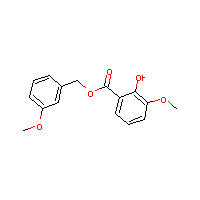

In [43]:
draw_mol_by_smiles('COc1cccc(COC(=O)c2cccc(OC)c2O)c1')

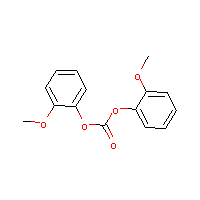

In [44]:
draw_mol_by_smiles('COc1ccccc1OC(=O)Oc1ccccc1OC')

In [45]:
x_embedding2.loc['COc1ccccc1OC(=O)Oc1ccccc1OC'].values.reshape(1,-1)

array([[  5.7448177,  45.429264 ,  34.519726 ,  31.130407 ,  -1.7580991,
         -1.7580993,  -1.622563 ,  54.09375  ,  -1.7580993,  24.39327  ,
         -1.7580993,  15.099196 ,  -1.7580993,  -1.7580993,  -1.7575164,
         -1.7580993,  -1.7580993,  -1.7580993,  -1.7580993,  -1.7580993,
         -1.7580993,  23.093681 ,  -1.7580993,  -1.7578342,  -1.7580993,
          5.5021906,  -1.758099 ,  -1.7580993, 106.11967  ,  -1.7580993]],
      dtype=float32)

In [46]:
print_closest_words(x_embedding=x_embedding2, x_query='COc1ccccc1OC(=O)Oc1ccccc1OC')

COc1ccc(OC(C)C(=O)Oc2ccccc2OC)cc1 [10.309029]
COc1cc(CC(=O)c2ccc(O)c(OC)c2)ccc1O [10.9470005]
COc1ccc(CC(=O)c2cc(OC)c(O)cc2O)cc1 [11.532066]
COc1ccc(CC(=O)c2ccc(O)cc2O)c(OC)c1 [11.589741]
COc1ccc(OC)c(CC(=O)c2ccc(O)cc2O)c1 [11.589741]


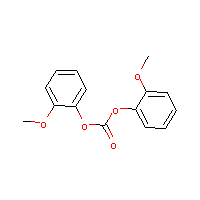

In [109]:
draw_mol_by_smiles('COc1ccccc1OC(=O)Oc1ccccc1OC')

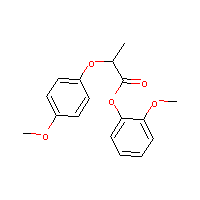

In [47]:
draw_mol_by_smiles('COc1ccc(OC(C)C(=O)Oc2ccccc2OC)cc1')

In [48]:
print_closest_words(x_embedding=x_embedding2, x_query='COC(=O)c1cc(Br)cc(Br)c1O')

COC(=O)c1cc(Br)c(O)c(Br)c1 [6.539438]
COC(=O)c1cc(Cl)cc(Br)c1O [6.544733]
COC(=O)c1cc(Br)cc(Cl)c1O [7.2633834]
COC(=O)COc1c(Br)cccc1Br [8.101522]
COCC(=O)Oc1c(Br)cccc1Br [8.270285]


In [49]:
print_closest_words(x_embedding=x_embedding2, x_query='COC(=O)c1cc(Br)cc(Br)c1O', add_vec=ch2)

COC(=O)c1cc(Br)cc(Br)c1O [12.590632]
CCOC(=O)c1occ(Br)c1Br [13.510105]
COC(=O)CCOc1c(Br)cccc1Br [14.2250185]
COC(=O)c1c(F)ccc(OC)c1Br [14.543065]
COCCCC(=O)Oc1ccc(Br)cc1F [15.260196]


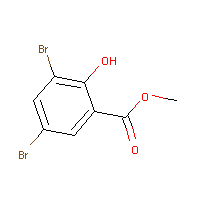

In [50]:
draw_mol_by_smiles('COC(=O)c1cc(Br)cc(Br)c1O')

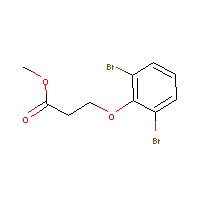

In [52]:
draw_mol_by_smiles('COC(=O)CCOc1c(Br)cccc1Br')

In [53]:
print_closest_words(x_embedding=x_embedding2, x_query='CCOC(=O)COc1ccc(Br)cc1', add_vec=ch2)

CCOC(=O)COc1cccc(Br)c1 [12.247801]
CCOC(=O)COc1ccc(Br)cc1 [12.590632]
CCOC(=O)CCCOc1ccc(Br)cc1 [12.717602]
CCOC(=O)CCOc1ccc(Br)cc1 [13.238694]
CCOCCOC(=O)c1ccc(Br)cc1 [13.358435]


In [54]:
print_closest_words(x_embedding=x_embedding2, x_query='O=C(OCC1CCCO1)c1cccc(Br)c1')

O=C(OCC1CCCO1)c1ccccc1Br [5.00119]
Cc1cc(Br)ccc1C(=O)OCC1CCCO1 [6.1837816]
O=C(OCC1CCCCO1)c1ccccc1Br [6.4755635]
O=C(CCc1ccccc1Br)OCC1CCCO1 [7.802787]
O=C(CCC1CCCO1)Oc1cccc(Br)c1 [8.092612]


In [65]:
print_closest_words(x_embedding=smiles_x_train_test, x_query='O=C(OCC1CCCO1)c1cccc(Br)c1')

O=C(OCC1CCCO1)c1ccccc1Br [24.38688849]
O=C(CC1CCCO1)c1ccc(Br)cc1 [35.38200695]
O=C(Oc1cccc(Br)c1)C1CCCO1 [37.04660933]
O=C(OCC1CCCCO1)c1ccccc1Br [38.2277591]
O=C(CCC1CCCO1)Oc1cccc(Br)c1 [42.62281528]


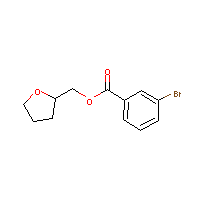

In [55]:
draw_mol_by_smiles('O=C(OCC1CCCO1)c1cccc(Br)c1')

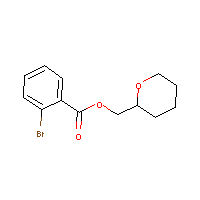

In [68]:
draw_mol_by_smiles('O=C(OCC1CCCCO1)c1ccccc1Br')

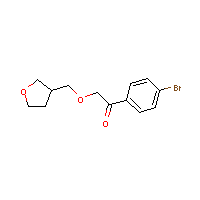

In [154]:
draw_mol_by_smiles('O=C(COCC1CCOC1)c1ccc(Br)cc1')

In [117]:
o = get_minus_result(x_embedding=x_embedding2, x='O=c1c(O)c(-c2ccc(O)cc2)oc2ccccc12', y='O=c1c(O)c(-c2ccc(O)cc2)oc2cccc(O)c12')
o

array([[-1.6928554e-02, -2.3820286e+00, -2.1684976e+00, -2.0108795e-01,
        -1.9508076e+00, -4.7084177e-01,  1.0815144e-02,  1.6812086e-03,
        -2.3104323e-01, -1.5218520e+00,  1.5106893e-01, -7.7001417e-01,
        -1.2215148e+00,  2.1910667e-04,  2.3959875e-03,  1.1633635e-03,
         1.0663509e-02, -2.5437832e-02, -9.1753006e-03, -2.9414892e-03,
        -7.7086496e-01, -4.0419579e-02,  6.9106102e-01,  3.0494794e-01,
         6.2769651e-03,  6.6191912e-02,  5.0997734e-02, -5.8038527e-01,
        -1.2340322e+00, -4.0850639e-03]], dtype=float32)

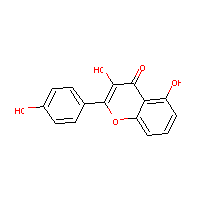

In [118]:
draw_mol_by_smiles('O=c1c(O)c(-c2ccc(O)cc2)oc2cccc(O)c12')

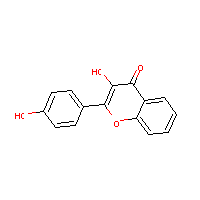

In [119]:
draw_mol_by_smiles('O=c1c(O)c(-c2ccc(O)cc2)oc2ccccc12')

In [120]:
print_closest_words(x_embedding=x_embedding2, x_query='Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1', add_vec=o)

Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1 [4.685711]
N#Cc1nc(Cc2ccccc2)oc1N1CCCC1 [4.685711]
Cc1ccccc1-c1nc(C#N)c(N2CCCC2)o1 [4.685711]
Cc1cccc(-c2nc(C#N)c(N3CCCC3)o2)c1 [4.685711]
Cc1cc2cc(CCC#N)c(N3CCCC3)nc2cc1C [6.163431]


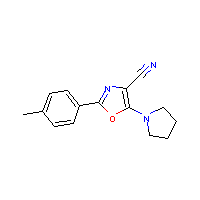

In [121]:
draw_mol_by_smiles('Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1')

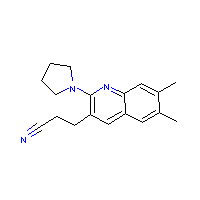

In [123]:
draw_mol_by_smiles('Cc1cc2cc(CCC#N)c(N3CCCC3)nc2cc1C')

In [124]:
print_closest_words(x_embedding=x_embedding2, x_query='Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1', add_vec=ch2)

Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1 [4.3305297]
N#Cc1nc(Cc2ccccc2)oc1N1CCCC1 [4.3305297]
Cc1ccccc1-c1nc(C#N)c(N2CCCC2)o1 [4.3305297]
Cc1cccc(-c2nc(C#N)c(N3CCCC3)o2)c1 [4.3305297]
CCNc1oc(C2CC2c2ccccc2)nc1C#N [6.1351995]


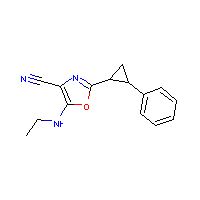

In [125]:
draw_mol_by_smiles('CCNc1oc(C2CC2c2ccccc2)nc1C#N')  # good example

##### similarity in fragment embedding

In [126]:
print_closest_words(x_embedding=frag2vec, x_query='CC')

C1CNSCCN1 [3.3470687]
C1COSCSO1 [3.3618871]
C1CC2CCC(C1)N2 [3.479212]
C1=CC2CC1C2 [3.50622987]
C1=CSN=CS1 [3.51665946]


In [127]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CC')

C [3.7849011]
C1=CC=CCC=C1 [5.029673]
CO [5.634586]
N [5.7525043]
C1=CC2CC(NCN2)O1 [5.9699497]


In [128]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CO')

CC [5.634586]
C [5.790043]
C1NNCO1 [6.7325478]
C1CC2COCC(C1)C2 [7.017662]
N [7.081011]


In [129]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C=C')

C=O [7.254423]
C1=CCCCC1 [7.731961]
C1CC2CCCC(C1)O2 [7.9319043]
C1CNSCCN1 [8.348729]
C1CC2COCC(CN1)N2 [8.533664]


In [170]:
double_bond = get_minus_result(x_embedding=frag_embedding_df, x='C=C', y='CC')
double_bond

array([[-0.9069163 ,  0.16055357, -1.4519948 ,  0.04600358,  2.1111865 ,
         0.94069785, -0.33108783,  0.00733316,  0.02371764, -0.3574866 ,
         2.11189   ,  1.2330089 ,  1.6423912 ,  1.6493165 ,  0.5750477 ,
        -0.00603211,  1.0300648 ,  3.5397837 ,  1.1197469 , -0.08535624,
         0.27110136,  0.1865567 , -0.07768476,  1.6632302 ,  1.0584667 ,
        -1.3718281 ,  0.21978402, -2.4010406 ,  0.13508382,  1.2698841 ]],
      dtype=float32)

In [171]:
double_bond2 = get_minus_result(x_embedding=frag_embedding_df, x='C=O', y='CO')
double_bond2

array([[-1.0754894 , -0.05029994, -0.9682723 ,  0.01637173,  3.1190686 ,
         0.2904792 , -1.7564679 , -0.03005278, -0.39539814, -1.7665595 ,
         0.6097307 , -1.3078978 ,  2.4683962 ,  0.09237754, -0.7451295 ,
         0.1150409 ,  0.30381685,  2.800765  ,  0.45277417,  0.6171602 ,
         0.23249733,  0.35240924,  0.04863632, -0.2631368 , -0.09964848,
         0.67061937,  1.0381212 , -0.4477899 ,  1.2853549 , -0.17619288]],
      dtype=float32)

In [172]:
double_bond3 = get_minus_result(x_embedding=frag_embedding_df, x='C=S', y='CS')
double_bond3

array([[-1.3957481 , -0.08041072, -1.3055601 , -0.00601339,  1.2437274 ,
        -1.1243701 , -2.16369   ,  0.43716812, -1.4693278 ,  0.51733625,
        -1.0354639 , -1.0465071 ,  1.3476306 ,  0.04740214,  1.6594639 ,
         0.3608284 ,  0.13601375,  1.9363195 , -0.7505995 , -0.16096044,
        -0.02901536,  1.1739947 , -0.31962013, -0.18861854, -0.6297839 ,
        -0.17125994,  0.12829292,  1.6007774 ,  1.075871  ,  0.00354147]],
      dtype=float32)

In [173]:
double_bond4 = get_minus_result(x_embedding=frag_embedding_df, x='C=N', y='CN')
double_bond4

array([[-0.8261296 ,  0.41114938, -1.6881613 ,  0.32293153,  3.2755349 ,
         0.18846641, -2.459127  ,  5.5993958 , -0.1279794 , -0.3589108 ,
        -3.6940436 , -2.097483  ,  2.7329798 ,  0.21572757,  2.1169827 ,
         2.0556507 , -0.6032865 ,  4.818708  , -1.7358465 ,  0.1737749 ,
        -1.02369   ,  2.7960978 , -1.5079298 ,  1.5021176 , -1.8424561 ,
        -0.30885392,  0.1059857 ,  3.3131592 , -0.19692159,  3.029746  ]],
      dtype=float32)

In [174]:
double_bond_mean = np.concatenate((double_bond, double_bond2, double_bond3, double_bond4)).mean(axis=0)
double_bond_mean

array([-1.0510708 ,  0.11024807, -1.3534971 ,  0.09482336,  2.4373794 ,
        0.07381836, -1.6775932 ,  1.5034611 , -0.49224693, -0.49140516,
       -0.5019717 , -0.80471975,  2.0478494 ,  0.5012059 ,  0.9015912 ,
        0.631372  ,  0.21665221,  3.2738938 , -0.22848123,  0.1361546 ,
       -0.13727666,  1.1272646 , -0.4641496 ,  0.67839813, -0.37835544,
       -0.29533064,  0.37304598,  0.51627654,  0.57484704,  1.0317447 ],
      dtype=float32)

In [177]:
cal_distance(double_bond, double_bond3)

array([[8.072913]], dtype=float32)

In [182]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CC', add_vec=double_bond2)

C=O [3.5713756]
C=C [6.220685]
CC [6.2624974]
CF [6.711393]
C1=CC=CCC=C1 [6.847985]


In [184]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CO', add_vec=double_bond2)

C=O [2.0647654e-07]
CC [6.119925]
CO [6.2624974]
C=C [6.4880624]
C [6.5317984]


In [185]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CS', add_vec=double_bond2)

C=O [4.620403]
C=S [5.671829]
CC [5.991187]
CS [6.2624974]
C [6.283827]


In [194]:
print_closest_words(x_embedding=frag_embedding_df, x_query='OS', add_vec=double_bond_mean)

OS [5.98756]
C1=CSCO1 [8.344847]
C1=CSCCC1 [8.429715]
C1=CSCCCC1 [8.565202]
C1=CNSCC1 [8.6135645]


In [199]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C1CC1', add_vec=double_bond)

C=C [6.690533]
C1CC1 [6.9603767]
C1=CC2C=CC(C1)CNC2 [7.3189626]
C1=CCC2CC(C=CN2)C1 [7.326511]
C1=CC2CCCCC(CC1)C2 [7.4690814]


##### triple bond

In [61]:
tri_bond = get_minus_result(x_embedding=frag_embedding_df, x='C#C', y='CC')

In [62]:
# print_closest_words(x_embedding=frag_embedding_df, x_query=tri_bond)

In [63]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CN', add_vec=tri_bond)

C#C [6.3061275]
C1=NSNC1 [9.890408]
C1=NCN=CC1 [11.603855]
C1=CCNC=C1 [11.807503]
C1CNSC1 [12.93584]


In [64]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CN')

C1CC2CNC(C1)N2 [4.72511]
C1CSCCO1 [5.2164364]
C1COCSC1 [5.8055387]
C1CC2CC(C1)N2 [5.8621697]
C1=COCC=N1 [5.9238305]


##### aromaticity, 芳香性

In [65]:
arom = get_minus_result(x_embedding=frag_embedding_df, x='C1=CC=CC=C1', y='C1CCCCC1')

In [66]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C1CCOCC1', add_vec=arom)

C1=CSCCNC1 [9.075472]
C1=NCCCSC1 [9.692141]
C1=CCC=CC1 [9.977199]
C1NCNSN1 [10.331807]
C1=COC=CC1 [10.397704]
